In [4]:
import sys
from pathlib import Path

# Resolve paths
project_root = Path.cwd().parent        # .../240-project
src_path = project_root / "src"         # .../240-project/src

# Add both to Python path
for p in [project_root, src_path]:
    if str(p) not in sys.path:
        sys.path.append(str(p))

# Now imports will work
from src.routing import fetch_or_load_data, calculate_segment_demand
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import config
import src

In [ ]:
import inspect
from src.routing import calculate_segment_demand

print(inspect.signature(calculate_segment_demand))

(network: network.BartNetwork, df: pandas.core.frame.DataFrame) -> dict


In [ ]:
from src.network import BartNetwork
network = BartNetwork()

In [ ]:
segment_demand_dict = calculate_segment_demand(network, df_raw)

Calculating shortest paths for all OD pairs...
Routing complete. Mapped demand to 400 segment-periods.


In [ ]:
type(segment_demand_dict)
len(segment_demand_dict)

400

In [ ]:
# Peek at a few items
list(segment_demand_dict.items())[:5]

[((12TH->WOAK, 'AM'), 3385.0104961832067),
 ((WOAK->EMBR, 'AM'), 5735.686068702289),
 ((EMBR->MONT, 'AM'), 3936.9904580152647),
 ((MONT->POWL, 'AM'), 2545.6211832061053),
 ((POWL->CIVC, 'AM'), 1959.6383587786258)]

In [14]:
segment_example = next(iter(segment_demand_dict.keys()))[0]
segment_example


12TH->WOAK

In [15]:
dir(segment_example)


['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__replace__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'u',
 'v']

In [16]:
import pandas as pd

records = []

for (segment, period), passengers in segment_demand_dict.items():
    records.append({
        "segment_from": segment.u,
        "segment_to": segment.v,
        "period": period,
        "avg_passengers": passengers
    })

segment_demand_df = pd.DataFrame(records)
segment_demand_df.head()


,segment_from,segment_to,period,avg_passengers
0,12TH,WOAK,AM,3385.010496
1,WOAK,EMBR,AM,5735.686069
2,EMBR,MONT,AM,3936.990458
3,MONT,POWL,AM,2545.621183
4,POWL,CIVC,AM,1959.638359


In [ ]:
segment_demand_df.shape

(400, 4)

In [ ]:
segment_demand_df.columns

Index(['segment_from', 'segment_to', 'period', 'avg_passengers'], dtype='object')

In [19]:
segment_demand_df.describe()

,avg_passengers
count,400.000000
mean,704.085342
std,817.937472
min,13.544529
25%,196.539122
50%,434.525573
75%,851.753101
max,5825.590649


In [23]:
segment_demand_df["segment"] = (
    segment_demand_df["segment_from"] + " → " + segment_demand_df["segment_to"]
)


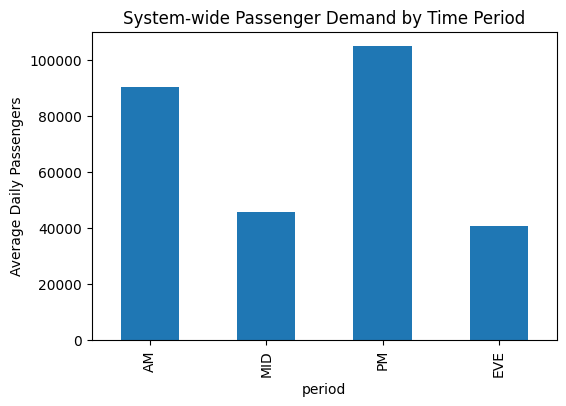

In [24]:
period_demand = (
    segment_demand_df
    .groupby("period")["avg_passengers"]
    .sum()
    .reindex(["AM", "MID", "PM", "EVE"])
)

period_demand.plot(kind="bar", figsize=(6,4))
plt.ylabel("Average Daily Passengers")
plt.title("System-wide Passenger Demand by Time Period")
plt.show()


In [26]:
transbay_segments = [
    ("WOAK", "EMBR"),
    ("EMBR", "WOAK")
]

transbay_df = segment_demand_df[
    segment_demand_df[["segment_from", "segment_to"]]
    .apply(tuple, axis=1)
    .isin(transbay_segments)
]


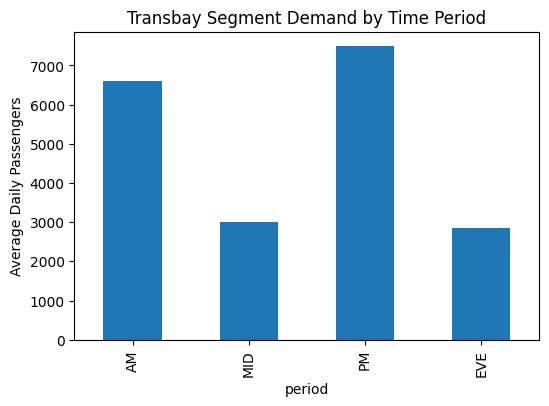

In [27]:
(
    transbay_df
    .groupby("period")["avg_passengers"]
    .sum()
    .reindex(["AM", "MID", "PM", "EVE"])
    .plot(kind="bar", figsize=(6,4))
)

plt.title("Transbay Segment Demand by Time Period")
plt.ylabel("Average Daily Passengers")
plt.show()


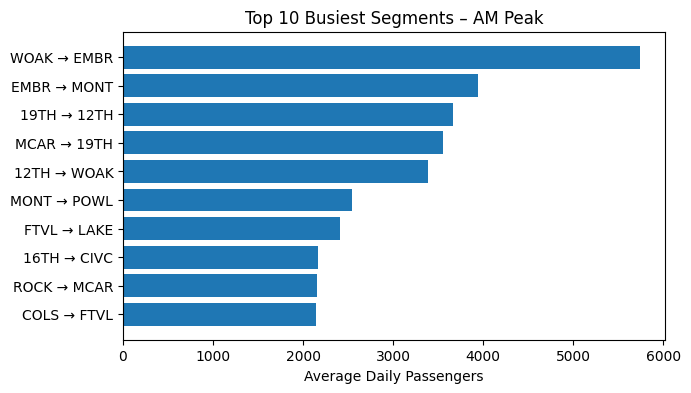

In [28]:
top_am_segments = (
    segment_demand_df[segment_demand_df["period"] == "AM"]
    .sort_values("avg_passengers", ascending=False)
    .head(10)
)

plt.figure(figsize=(7,4))
plt.barh(top_am_segments["segment"], top_am_segments["avg_passengers"])
plt.gca().invert_yaxis()
plt.xlabel("Average Daily Passengers")
plt.title("Top 10 Busiest Segments – AM Peak")
plt.show()


In [29]:
downtown_sf = ["EMBR", "MONT", "POWL", "CIVC"]

downtown_df = segment_demand_df[
    segment_demand_df["segment_from"].isin(downtown_sf)
]


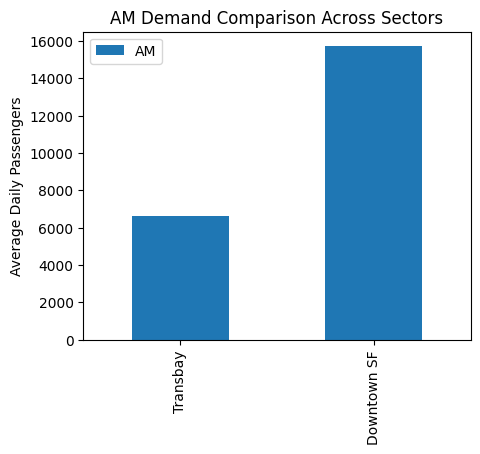

In [30]:
comparison = pd.DataFrame({
    "Transbay": (
        transbay_df[transbay_df["period"] == "AM"]["avg_passengers"].sum()
    ),
    "Downtown SF": (
        downtown_df[downtown_df["period"] == "AM"]["avg_passengers"].sum()
    )
}, index=["AM"])

comparison.T.plot(kind="bar", figsize=(5,4))
plt.ylabel("Average Daily Passengers")
plt.title("AM Demand Comparison Across Sectors")
plt.show()


In [32]:
sector_map = {
    "Transbay": [("WOAK","EMBR"), ("EMBR","WOAK")],
    "Downtown SF": [
        ("EMBR","MONT"), ("MONT","POWL"), ("POWL","CIVC")
    ]
}

rows = []

# Create a pandas Series of (from, to) pairs ONCE
segment_pairs = segment_demand_df[["segment_from", "segment_to"]].apply(tuple, axis=1)

for sector, segs in sector_map.items():
    sector_df = segment_demand_df[segment_pairs.isin(segs)]
    
    grouped = (
        sector_df
        .groupby("period")["avg_passengers"]
        .sum()
    )
    
    for period, val in grouped.items():
        rows.append((sector, period, val))

sector_period_df = pd.DataFrame(
    rows, columns=["sector", "period", "avg_passengers"]
)

pivot = sector_period_df.pivot(
    index="sector", columns="period", values="avg_passengers"
)

pivot


period,AM,EVE,MID,PM
sector,,,,
Downtown SF,8442.250000,2484.847328,3656.226718,6408.520038
Transbay,6610.346374,2863.057252,3006.180153,7487.030534


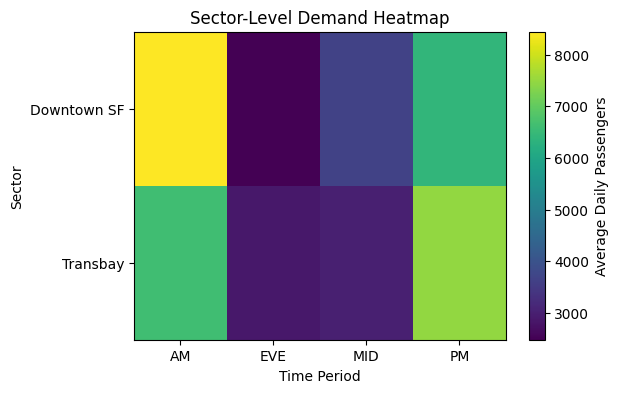

In [33]:
plt.figure(figsize=(6,4))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Average Daily Passengers")

plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)

plt.title("Sector-Level Demand Heatmap")
plt.xlabel("Time Period")
plt.ylabel("Sector")

plt.show()


In [35]:
# Define directed Transbay segments
transbay_in = [("WOAK", "EMBR")]   # East Bay → SF
transbay_out = [("EMBR", "WOAK")]  # SF → East Bay

# Create (from, to) pairs
segment_pairs = segment_demand_df[["segment_from", "segment_to"]].apply(tuple, axis=1)

# Filter inbound and outbound
in_df = segment_demand_df[segment_pairs.isin(transbay_in)]
out_df = segment_demand_df[segment_pairs.isin(transbay_out)]

# Aggregate by period
directional_transbay = pd.DataFrame({
    "Inbound (WOAK → EMBR)": in_df.groupby("period")["avg_passengers"].sum(),
    "Outbound (EMBR → WOAK)": out_df.groupby("period")["avg_passengers"].sum()
}).reindex(["AM", "MID", "PM", "EVE"])

directional_transbay


,Inbound (WOAK → EMBR),Outbound (EMBR → WOAK)
period,,
AM,5735.686069,874.660305
MID,1835.358015,1170.822137
PM,1661.439885,5825.590649
EVE,707.664122,2155.393130


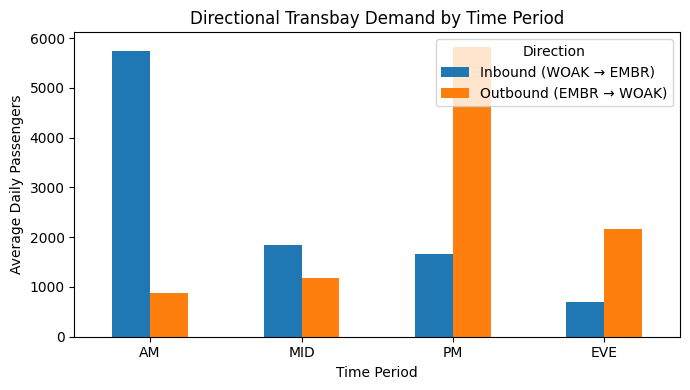

In [36]:
directional_transbay.plot(
    kind="bar",
    figsize=(7,4)
)

plt.ylabel("Average Daily Passengers")
plt.xlabel("Time Period")
plt.title("Directional Transbay Demand by Time Period")
plt.xticks(rotation=0)
plt.legend(title="Direction")
plt.tight_layout()
plt.show()


/var/folders/zc/f0nbsvfj78b35qzl6m0g8gbm0000gp/T/ipykernel_2182/2602402584.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["avg_passengers"].max() / x["avg_passengers"].mean())


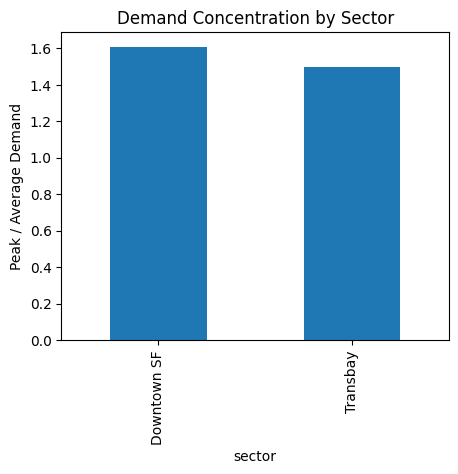

In [37]:
peakiness = (
    sector_period_df
    .groupby("sector")
    .apply(lambda x: x["avg_passengers"].max() / x["avg_passengers"].mean())
)

peakiness.plot(kind="bar", figsize=(5,4))
plt.ylabel("Peak / Average Demand")
plt.title("Demand Concentration by Sector")
plt.show()
